In [1]:
import os
gpus = [0]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import socket
import os
import sys
import pandas as pd
import scipy.io as sio
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import pylab
import h5py
import pickle
import seaborn as sns
import random
import collections
import logging
import datetime
import itertools
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import gc
import importlib
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("../..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
data_folder = os.path.abspath('/mnt/cube/kai/data_processed/bci/prelim_10_motif')
save_folder = os.path.abspath('/mnt/cube/kai/results/bci/prelim_10_motif')

# load data

In [10]:
input_output_df = pickle.load(open(os.path.join(data_folder, 'input_output_2021_04_23_04_57.p'), 'rb'))

In [11]:
input_output_df.tail()

,motif,step,input,output
1365,9,132,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.34626780131000034, -0.6976743063570495, -0..."
1366,9,133,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.4414303893804583, -0.6573171533142144, -1...."
1367,9,134,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...","[-0.45199486637298775, -0.6906773651003755, -0..."
1368,9,135,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.28211163644209253, -0.6644469578173456, -0..."
1369,9,136,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[-0.2459257798562328, -0.7444524827126306, -0...."


In [40]:
n_motifs = len(input_output_df.motif.value_counts())
n_steps = len(input_output_df.step.value_counts())

In [14]:
n_lookbacks, n_clusters = input_output_df.input.values[0].shape

In [16]:
print(n_lookbacks, n_clusters)

10 187


In [17]:
n_specs = input_output_df.output.values[0].shape[0]

# model parameters

In [19]:
l2_val = 0.001
dropout_val = 0.2
num_neurons = [20, 30]

# training parameters

In [54]:
num_ep = 1000
patience = 50
early_stopping = True
valid_split = 0.1
batch_size = 10
n_parts = 5
mode = 'motif_wise'

In [24]:
np.ceil(10/3).astype(int)

4

In [39]:
np.array(input_output_df[~input_output_df.motif.isin([4, 5])].input.values.tolist()).shape

(1096, 10, 187)

In [56]:
def train_test_split(input_output_df, n_parts, test_part, mode):
    if mode == 'motif_wise':
        motifs_per_part = np.ceil(n_motifs/n_parts).astype(int)
        test_motifs = np.arange(motifs_per_part*test_part, motifs_per_part*(test_part+1))
        test_input = np.array(input_output_df[input_output_df.motif.isin(test_motifs)].input.values.tolist())
        test_output = np.array(input_output_df[input_output_df.motif.isin(test_motifs)].output.values.tolist())
        train_input = np.array(input_output_df[~input_output_df.motif.isin(test_motifs)].input.values.tolist())
        train_output = np.array(input_output_df[~input_output_df.motif.isin(test_motifs)].output.values.tolist())
    elif mode == 'part_wise':
        steps_per_part = np.ceil(n_steps/n_parts).astype(int)
        test_steps = np.arange(steps_per_part*test_part, steps_per_part*(test_part+1))
        test_input = np.array(input_output_df[input_output_df.step.isin(test_steps)].input.values.tolist())
        test_output = np.array(input_output_df[input_output_df.step.isin(test_steps)].output.values.tolist())
        train_input = np.array(input_output_df[~input_output_df.step.isin(test_steps)].input.values.tolist())
        train_output = np.array(input_output_df[~input_output_df.step.isin(test_steps)].output.values.tolist())
    return train_input, train_output, test_input, test_output

In [57]:
train_input, train_output, test_input, test_output = train_test_split(input_output_df, 5, 4, 'motif_wise')

In [53]:
train_output.shape

(1096, 128)

# compile model

In [72]:
# run_name = f'{datetime.datetime.now():%Y_%m_%d_%H_%M}'
run_folder = extend_folder(save_folder, run_name)
test_output_compiled = list()
test_prediction_compiled = list()
history_compiled = list()

for test_index in range(n_parts):
    index_folder = extend_folder(run_folder, str(test_index))
    train_input, train_output, test_input, test_output = train_test_split(input_output_df, n_parts, test_index, mode)
    
    # compile model
    model = Sequential()
    model.add(LSTM(num_neurons[0], input_shape = (n_lookbacks, n_clusters), return_sequences=True, 
                   kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(LSTM(num_neurons[1], kernel_regularizer=l2(l2_val)))
    model.add(Dropout(dropout_val))
    model.add(Dense(n_specs, kernel_regularizer=l2(l2_val)))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    model_file = os.path.join(index_folder, 'weights-improvement.h5')
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
                 ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]
    history = model.fit(train_input, train_output, epochs=num_ep, batch_size=batch_size, verbose=1, 
                        validation_split=valid_split, callbacks=callbacks)
    
    # reload model to measure prediction loss
    del model
    model = load_model(model_file)
    
    # plot loss and validation loss over epochs
    fig = plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.savefig(os.path.join(index_folder, 'learning curve.png'))
    plt.close(fig)
    
    # test prediction, save to a pickle file
    test_prediction = model.predict(test_input)
    rmse = [np.sqrt(np.mean(np.square(np.array(prediction)-np.array(original)))) for prediction, original in zip(test_prediction, test_output)]
    save_file = os.path.join(index_folder,'results.p' )
    results_df = pd.DataFrame()
    results_df['prediction'] = list(test_prediction)
    results_df['target'] = list(test_output)
    results_df['rmse'] = rmse
    results_df.to_pickle(save_file)
    
    
    history_compiled.append([history.history['loss'], history.history['val_loss']])
    test_output_compiled+=list(test_output)
    test_prediction_compiled+=list(test_prediction)
    paragraph_print('Data appended', separation='-')

pickle.dump([test_output_compiled, 
             test_prediction_compiled, history_compiled], open(os.path.join(run_folder, 'all_results.p'), 'wb'))

Epoch 1/1000
99/99 [==============================] - 2s 19ms/step - loss: 0.3797 - val_loss: 0.1260
Epoch 2/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.1122 - val_loss: 0.0875
Epoch 3/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0811 - val_loss: 0.0669
Epoch 4/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0628 - val_loss: 0.0585
Epoch 5/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0525 - val_loss: 0.0475
Epoch 6/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0440 - val_loss: 0.0443
Epoch 7/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0394 - val_loss: 0.0395
Epoch 8/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0355 - val_loss: 0.0396
Epoch 9/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0332 - val_loss: 0.0405
Epoch 10/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0327 - val_lo

Epoch 82/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0365
Epoch 83/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0358
Epoch 84/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0145 - val_loss: 0.0359
Epoch 85/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0148 - val_loss: 0.0385
Epoch 86/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0143 - val_loss: 0.0379
Epoch 87/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0371
Epoch 88/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0143 - val_loss: 0.0385
Epoch 89/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0146 - val_loss: 0.0408
Epoch 90/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0.0360
Epoch 91/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0143 - val_l

Epoch 56/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0165 - val_loss: 0.0356
Epoch 57/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0160 - val_loss: 0.0400
Epoch 58/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0158 - val_loss: 0.0379
Epoch 59/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0159 - val_loss: 0.0362
Epoch 60/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0156 - val_loss: 0.0375
Epoch 61/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0153 - val_loss: 0.0327
Epoch 62/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0153 - val_loss: 0.0343
Epoch 63/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0157 - val_loss: 0.0352
Epoch 64/1000
99/99 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 0.0364
Epoch 65/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0151 - val_los

Data appended
--------------------------------------------------
Epoch 1/1000
99/99 [==============================] - 2s 18ms/step - loss: 0.3847 - val_loss: 0.1317
Epoch 2/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.1102 - val_loss: 0.0893
Epoch 3/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0777 - val_loss: 0.0733
Epoch 4/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0615 - val_loss: 0.0584
Epoch 5/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0501 - val_loss: 0.0500
Epoch 6/1000
99/99 [==============================] - 1s 15ms/step - loss: 0.0436 - val_loss: 0.0431
Epoch 7/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0383 - val_loss: 0.0402
Epoch 8/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0355 - val_loss: 0.0382
Epoch 9/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0340 - val_loss: 0.0406
Epoch 10/1000
99/99 [=====

99/99 [==============================] - 1s 11ms/step - loss: 0.0145 - val_loss: 0.0364
Epoch 82/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0140 - val_loss: 0.0406
Epoch 83/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0142 - val_loss: 0.0390
Epoch 00083: early stopping
Data appended
--------------------------------------------------
Epoch 1/1000
99/99 [==============================] - 2s 19ms/step - loss: 0.3799 - val_loss: 0.1299
Epoch 2/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.1117 - val_loss: 0.0887
Epoch 3/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0785 - val_loss: 0.0669
Epoch 4/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0610 - val_loss: 0.0600
Epoch 5/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0487 - val_loss: 0.0517
Epoch 6/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0424 - val_loss: 0.0458
Epoch 7/10

99/99 [==============================] - 1s 10ms/step - loss: 0.0150 - val_loss: 0.0399
Epoch 79/1000
99/99 [==============================] - 1s 11ms/step - loss: 0.0148 - val_loss: 0.0375
Epoch 80/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0.0397
Epoch 81/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0149 - val_loss: 0.0405
Epoch 82/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0.0422
Epoch 83/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0.0427
Epoch 84/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0147 - val_loss: 0.0375
Epoch 85/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0145 - val_loss: 0.0412
Epoch 86/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0156 - val_loss: 0.0396
Epoch 87/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - val_loss: 0

Epoch 51/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0176 - val_loss: 0.0240
Epoch 52/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0173 - val_loss: 0.0217
Epoch 53/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0171 - val_loss: 0.0229
Epoch 54/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0168 - val_loss: 0.0222
Epoch 55/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0166 - val_loss: 0.0235
Epoch 56/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0165 - val_loss: 0.0259
Epoch 57/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0164 - val_loss: 0.0216
Epoch 58/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0262
Epoch 59/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0162 - val_loss: 0.0224
Epoch 60/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0157 - val_lo

99/99 [==============================] - 1s 9ms/step - loss: 0.0123 - val_loss: 0.0184
Epoch 132/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0121 - val_loss: 0.0207
Epoch 133/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0122 - val_loss: 0.0211
Epoch 134/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0121 - val_loss: 0.0200
Epoch 135/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0121 - val_loss: 0.0201
Epoch 136/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0121 - val_loss: 0.0193
Epoch 137/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0117 - val_loss: 0.0201
Epoch 138/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0119 - val_loss: 0.0200
Epoch 139/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0120 - val_loss: 0.0216
Epoch 140/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0122 - val_los

99/99 [==============================] - 1s 9ms/step - loss: 0.0116 - val_loss: 0.0186
Epoch 212/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0115 - val_loss: 0.0196
Epoch 213/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 0.0201
Epoch 214/1000
99/99 [==============================] - 1s 9ms/step - loss: 0.0116 - val_loss: 0.0221
Epoch 215/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0119 - val_loss: 0.0181
Epoch 216/1000
99/99 [==============================] - 1s 10ms/step - loss: 0.0115 - val_loss: 0.0190
Epoch 00216: early stopping
Data appended
--------------------------------------------------


TypeError: write() argument must be str, not bytes

In [73]:
pickle.dump([test_output_compiled, 
             test_prediction_compiled, history_compiled], open(os.path.join(run_folder, 'all_results.p'), 'wb'))

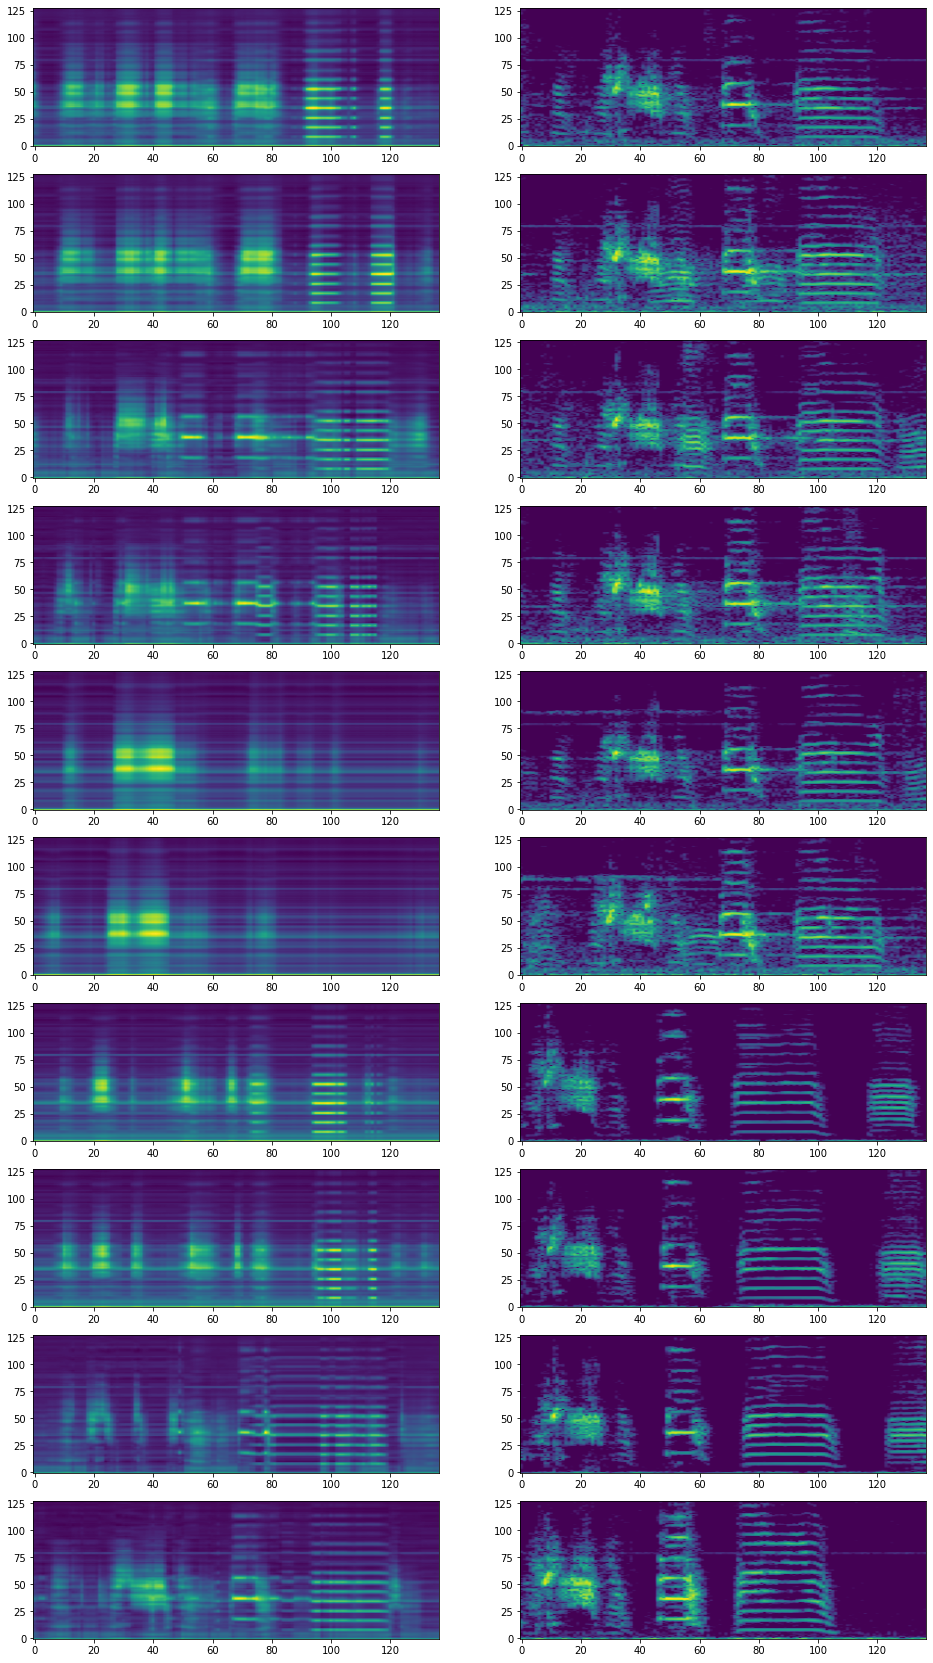

In [81]:
fig, ax = plt.subplots(10, 2, figsize=(16,30))
for i in range(n_motifs):
    ax[i][0].imshow(np.array(test_prediction_compiled[i*137:(i+1)*137]).T, origin='lower', aspect='auto')
    ax[i][1].imshow(np.array(test_output_compiled[i*137:(i+1)*137]).T, origin='lower', aspect='auto')